In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from PIL import Image

from ResNet import Bottleneck, ResNet, ResNet50

In [81]:
class Dataset():
    def __init__(self, list_image_path, list_txt, train: bool):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.label  = list_txt

        self.train = train

        self.transform_train = transforms.Compose([
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomCrop(32, padding=4),
            transforms.Resize(size=[256,256]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        if self.train:
            image = self.transform_train(Image.open(self.image_path[idx]))
        else:
            image = self.transform_test(Image.open(self.image_path[idx]))

        label = self.label[idx]
        return image, label

In [82]:
df = pd.read_csv('data.csv')

dataloaders = {}

for x in ['train', 'test']:
    df_ = df[(df['tag']==x)]

    img_path = df_['image_path'].tolist()
    labels = df_['int_label'].tolist()

    print(f'length of {x} split: {len(labels)}')

    dataset = Dataset(img_path, labels, train=(x=='train'))
    dataloaders[x] = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

    print(f'Num of Batches in {x} dataloader: {len(dataloaders[x])}')

    # if x == 'train':
    #     train_dataset = Dataset(img_path, labels, train=True)
    #     trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    # else:
    #     test_dataset = Dataset(img_path, labels, train=True)
    #     testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)
        


length of train split: 677
Num of Batches in train dataloader: 11
length of test split: 197
Num of Batches in test dataloader: 4


In [83]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [84]:
len(next(iter(dataloaders['train'])))

2

64


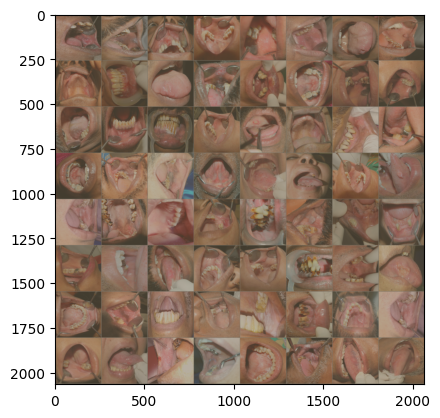

In [86]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(len(inputs))
imshow(out)

In [35]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [37]:
net = ResNet50(10).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [38]:
EPOCHS = 200
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            
print('Training Done')

Loss [1, 100](epoch, minibatch):  8.839240016937255
Loss [1, 200](epoch, minibatch):  2.8543614387512206
Loss [1, 300](epoch, minibatch):  2.5090506088733675
Loss [2, 100](epoch, minibatch):  2.1302514731884004
Loss [2, 200](epoch, minibatch):  1.9953344476222992
Loss [2, 300](epoch, minibatch):  1.9380652523040771
Loss [3, 100](epoch, minibatch):  1.855226961374283
Loss [3, 200](epoch, minibatch):  1.7927296078205108
Loss [3, 300](epoch, minibatch):  1.743425933122635
Loss [4, 100](epoch, minibatch):  1.7187504696846008
Loss [4, 200](epoch, minibatch):  1.687288955450058
Loss [4, 300](epoch, minibatch):  1.665401849746704
Loss [5, 100](epoch, minibatch):  1.6413379180431367
Loss [5, 200](epoch, minibatch):  1.6188793969154358
Loss [5, 300](epoch, minibatch):  1.591441843509674
Loss [6, 100](epoch, minibatch):  1.582551372051239
Loss [6, 200](epoch, minibatch):  1.5571859669685364
Loss [6, 300](epoch, minibatch):  1.5410805189609527
Loss [7, 100](epoch, minibatch):  1.5283722984790802


In [39]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on 10,000 test images: ', 100*(correct/total), '%')

Accuracy on 10,000 test images:  85.66 %
